In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import numpy as np
import plotly.express as px
import plotly.offline as pyo

# Define Functions

In [2]:
def summarySE(data=None, measurevar=None, groupvars=None, na_rm=False, conf_interval=0.95):
    # New version of length which can handle NA's: if na_rm==True, don't count them
    def length2(x, na_rm=False):
        if na_rm:
            return np.sum(~np.isnan(x))
        else:
            return len(x)

    # This does the summary. For each group's data frame, return a DataFrame with N, mean, and sd
    def summary_fun(xx, col):
        return pd.Series({
            'N': length2(xx[col], na_rm=na_rm),
            'mean': np.mean(xx[col]),
            'sd': np.std(xx[col])
        })

    datac = data.groupby(groupvars, dropna=True).apply(summary_fun, col=measurevar).reset_index()

    # Rename the "mean" column
    datac.rename(columns={'mean': measurevar}, inplace=True)

    datac['se'] = datac['sd'] / np.sqrt(datac['N'])  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval:
    # e.g., if conf_interval is 0.95, use 0.975 (above/below), and use df=N-1
    ci_mult = t.ppf(conf_interval / 2 + 0.5, datac['N'] - 1)
    datac['ci'] = datac['se'] * ci_mult

    return datac 




# # Example data (replace these paths with your actual data paths)
# L1_data = {
#     'subject': ['A', 'B', 'C'],
#     'support': [1, 2, 1],
#     'recall': [0.8, 0.6, 0.7]
# }

# L2_data = {
#     'subject': ['A', 'B', 'C'],
#     'support': [1, 2, 1],
#     'recall': [0.7, 0.5, 0.6]
# }

# L1 = pd.DataFrame(L1_data)
# L2 = pd.DataFrame(L2_data)

# LINE = pd.concat([L1, L2], ignore_index=True)


In [32]:
def plot_sensitivity_boxstrip(df, x_column, y_column,
                              title, palette):
    """
    Plot sensitivity using Seaborn with boxplot and stripplot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing sensitivity data.
    - x_column (str): Column for the x-axis.
    - y_column (str): Column for the y-axis.
    - palette (list): Color palette for the plot.

    Returns:
    - None
    """

    plt.figure(figsize=(10, 6))

    # Boxplot
    sns.boxplot(x=x_column, y=y_column, data=df, hue="subject",
                width=0.5, linewidth=0.2, palette=palette, fliersize=0)

    # Scatter plot with jitter and dodge
    sns.stripplot(x=x_column, y=y_column, data=df, hue="subject",
                  palette=palette, s=5, dodge=True, jitter=True,
                  alpha=0.7, edgecolor='black', linewidth=0.2)

    plt.xlabel("")
    plt.ylabel("")
    plt.ylim(0, 1.05)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0, 1], labels=[">=1 read", ">=2 reads"])

    # Remove the legend
    plt.legend().set_visible(False)

    # Set the color palette for fill and color
    sns.set_palette(palette)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.title(title)

    # Adjust font sizes
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('axes', labelsize=24)

    plt.show()

## Plotly
# import plotly.express as px

# def plot_sensitivity_boxstrip(df, x_column, y_column, title, palette):
#     """
#     Plot sensitivity using Plotly Express with box plot and strip plot.

#     Parameters:
#     - df (pd.DataFrame): DataFrame containing sensitivity data.
#     - x_column (str): Column for the x-axis.
#     - y_column (str): Column for the y-axis.
#     - palette (list): Color palette for the plot.

#     Returns:
#     - None
#     """

#     # Create box plot with points
#     fig = px.box(df, x=x_column, y=y_column, color="subject",
#                  points="all", color_discrete_sequence=palette,
#                  notched=True, boxmode="overlay")

#     # Update layout for box plot
#     fig.update_traces(marker=dict(size=8, line=dict(width=1, color='black')))

#     # Update layout
#     fig.update_layout(
#         title=title,
#         xaxis_title="",
#         yaxis_title="",
#         xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=[">=1 read", ">=2 reads"]),
#         yaxis=dict(range=[0, 1.05], tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1]),
#         font=dict(size=12),
#         legend=dict(title=""),
#         hovermode="closest",
#         hoverlabel=dict(bgcolor="white", font_size=12),
#     )

#     # Show the figure
#     fig.show()

In [38]:
def create_line_plot(sens):
    fig = px.line(sens, x='Freq', y='Sensitivity', color='Depth', 
                  line_group='Depth', 
                  markers=True, 
                  color_discrete_sequence=px.colors.qualitative.Set1,
                  symbol='Depth',
                  symbol_sequence=[1, 3, 16, 17])

    fig.update_traces(marker=dict(size=10))

    fig.update_layout(
        xaxis_title="Level of Mosaicism (%)",
        yaxis_title="Sensitivity (L1)",
        xaxis=dict(
            type='log',
            tickvals=[0.04, 0.2, 1, 5, 25],
            range=[-2, 3.25]  # Adjusted range to cover values up to 25
        ),
        yaxis=dict(
            range=[0, 1],
            tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1]
        ),
        legend=dict(
            traceorder='normal',
            orientation='v',
            y=1.1,
            x=0.01,
            font=dict(size=16),
            title=dict(text='Depth', font=dict(size=18, color='black'))
        ),
        font=dict(
            family="Arial, sans-serif",
            size=18,
            color="RebeccaPurple"
        )
    )

    return fig


# 1. Sensitivity, Precision, False Positive Plots

In [4]:
df_L1_data = pd.read_excel('exampleData/NIHMS1648953-supplement-1648953_SD_Fig_2.xlsx', sheet_name='Fig2a_one_read')
df_L2_data = pd.read_excel('exampleData/NIHMS1648953-supplement-1648953_SD_Fig_2.xlsx', sheet_name='Fig2a_two_reads')

In [5]:
LINE = pd.concat([df_L1_data, df_L2_data], ignore_index=True)
LINE['support'] = LINE['support'].str.extract('(\d+)', expand=False).astype(float)

In [6]:
LINE

,subject,sample,support,cutoff,recall,precision,FP
0,F2noMDA,Sample_316-BG-clone19,1.0,0.5,0.506423,0.947320,57
1,F2noMDA,Sample_316-clone20,1.0,0.5,0.498718,0.961285,47
2,F2noMDA,Sample_316-clone21,1.0,0.5,0.501931,0.964551,43
3,F2noMDA,Sample_316-FR-clone1,1.0,0.5,0.573609,0.987127,25
4,F2noMDA,Sample_316-FR-clone11,1.0,0.5,0.561694,0.979133,39
...,...,...,...,...,...,...,...
131,F3noMDA,Sample_320-FR-clone7,2.0,0.5,0.441807,1.000000,0
132,F3noMDA,Sample_320-FR-clone8,2.0,0.5,0.419312,1.000000,0
133,F3noMDA,Sample_320-FR-clone9,2.0,0.5,0.436522,1.000000,0
134,F3noMDA,Sample_320-FR-tissue,2.0,0.5,0.452381,0.998580,2


In [7]:
# Define the color palette
cbPalette = ["#E41A1C", "#377EB8", "#4DAF4A"]

## 1.1. RetroSom

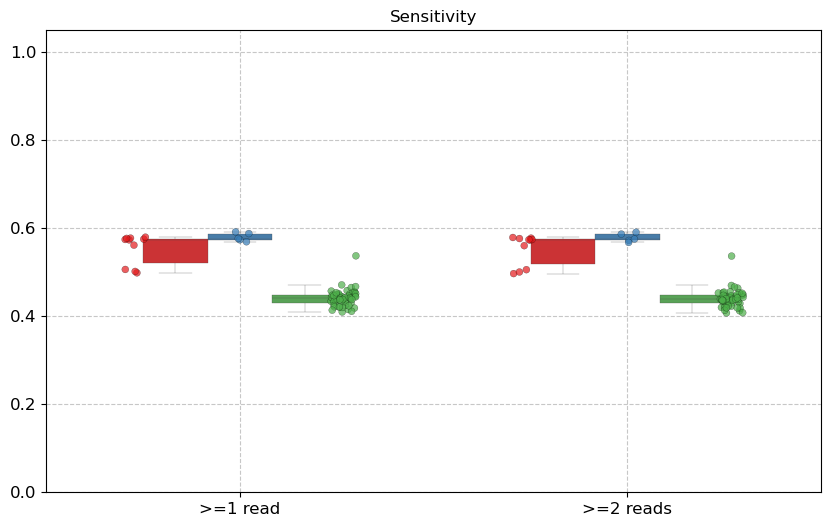

In [33]:
plot_sensitivity_boxstrip(LINE,"support","recall",
                          "Sensitivity",cbPalette)

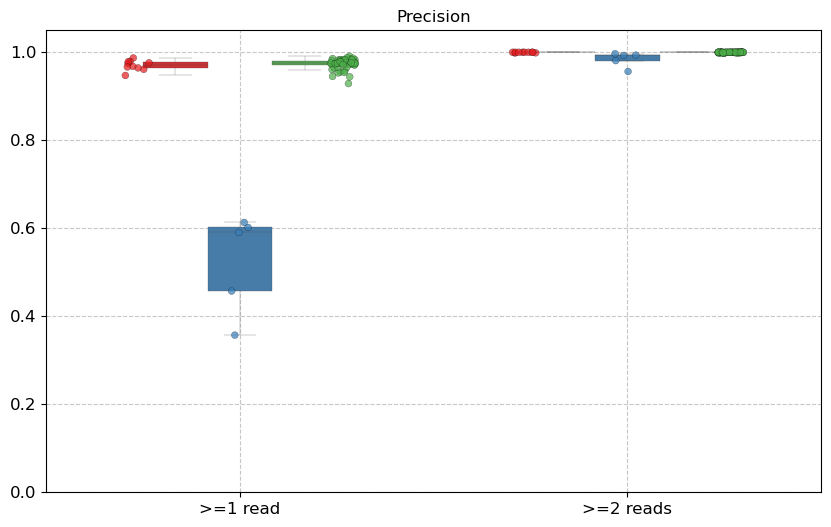

In [34]:
plot_sensitivity_boxstrip(LINE,"support","precision",
                          "Precision",
                          cbPalette)

## 1.2. xTea

# 2. Sensitivity and Precision per Level of Mosaicism

In [35]:
dat = pd.read_excel('exampleData/NIHMS1648953-supplement-1648953_SD_Fig_2.xlsx', sheet_name='Fig2c,d')

In [36]:
# Extract columns 1 to 3 for 'sens'
sens = dat.iloc[:, :3]

# Extract all columns except the third for 'prec'
prec = dat.iloc[:, :-1]

# Convert 'Depth' columns to factors
sens['Depth'] = sens['Depth'].astype('category')
prec['Depth'] = prec['Depth'].astype('category')

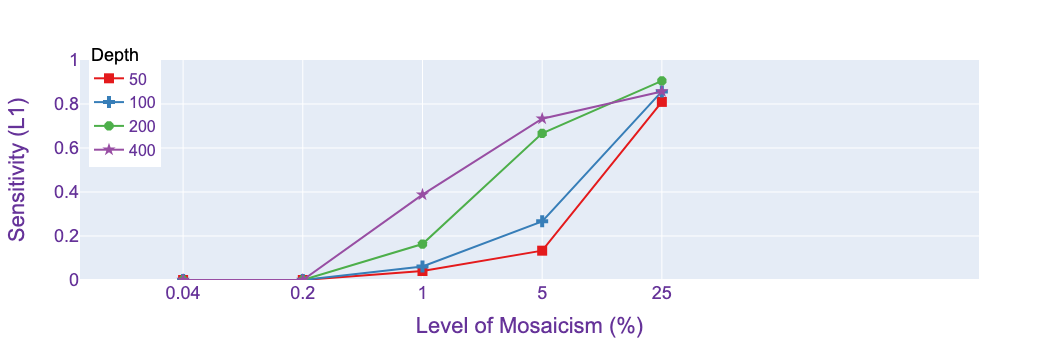

In [39]:
create_line_plot(sens)